In [1]:
import os    
os.environ['THEANO_FLAGS'] = "device=gpu, floatX=float32" 
import lasagne

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


In [2]:
from theano.tensor.signal.pool import pool_2d
import theano
import theano.tensor as T
import numpy as np
import sklearn.datasets
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
print(theano.config.device)
print(theano.config.floatX)

gpu
float32


In [3]:
print('a')
import cifar10
print ('b')
cifar10.maybe_download_and_extract()
print('c')
class_names = cifar10.load_class_names()
class_names

a
b
Data has apparently already been downloaded and unpacked.
c
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

In [4]:
X_train, y_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [5]:
X_test, y_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [7]:
X_test[0].shape
np.zeros((3, 32, 32)).shape

(3L, 32L, 32L)

In [8]:
temp = np.einsum('ijkl->iljk', X_train)

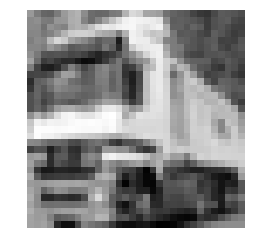

In [9]:
plt.imshow(temp[1][0][:][:], interpolation='nearest', cmap=plt.cm.gray)
#plt.title("Label: {}".format(dataset['train']['y'][0]))
plt.gca().set_axis_off()

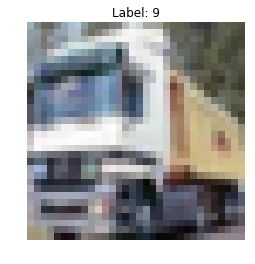

In [10]:
plt.imshow(X_train[1][:][:], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(y_train[1]))
plt.gca().set_axis_off()

In [11]:
X_train = np.einsum('ijkl->iljk', X_train)
X_train = X_train.astype(theano.config.floatX)

In [12]:
X_test = np.einsum('ijkl->iljk', X_test)
X_test = X_test.astype(theano.config.floatX)

In [13]:
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]
len(X_train)

40000

In [14]:
#############################

In [36]:
input_shape = X_train.shape
input_layer = lasagne.layers.InputLayer(
    shape=(None, input_shape[1], input_shape[2], input_shape[3])) ## None bo nie wiem ile będzie obrazkow

In [48]:
convolutional_layer = lasagne.layers.Conv2DLayer(
    input_layer, 
    num_filters=12,
    filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.rectify, 
    W=lasagne.init.HeNormal(gain='relu'))
#mozna ustawic krok filtru(stride) An integer or a 2-element tuple specifying the stride of the convolution operation.
# dorzucanie 0 na brzegach pad (int, iterable of int, ‘full’, ‘same’ or ‘valid’ (default: 0))

In [49]:
pooling_layer = lasagne.layers.MaxPool2DLayer(
    convolutional_layer, 
    pool_size=(2, 2))
#stride, pad, ignore border

In [50]:
dropout_layer = lasagne.layers.DropoutLayer(
    pooling_layer,
    p=0.3)

In [51]:
dense_layer = lasagne.layers.DenseLayer(
    dropout_layer, 
    num_units=1024,###################
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

In [52]:
dropout_layer2 = lasagne.layers.DropoutLayer(
    dense_layer,
    p=0.5)

In [53]:
dense_layer2 = lasagne.layers.DenseLayer(
    dropout_layer2, 
    num_units=512,###################
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

In [54]:
dropout_layer3 = lasagne.layers.DropoutLayer(
    dense_layer2,
    p=0.5)

In [55]:
dense_layer3 = lasagne.layers.DenseLayer(
    dropout_layer3, 
    num_units=256,###################
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

In [56]:
dropout_layer4 = lasagne.layers.DropoutLayer(
    dense_layer3,
    p=0.5)

In [57]:
output_layer = lasagne.layers.DenseLayer(
    dropout_layer4,
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

In [ ]:
true_output = T.ivector('true_output')
loss_train = lasagne.objectives.categorical_crossentropy(
    lasagne.layers.get_output(output_layer),
        true_output).mean()#crossentropy do softmaxu
all_params = lasagne.layers.get_all_params(output_layer)
updates = lasagne.updates.adadelta(loss_train, all_params)################# Use ADADELTA for updates
train = theano.function([input_layer.input_var, true_output], loss_train, updates=updates)#wejscie, wyjscie, updaty
get_output = theano.function([input_layer.input_var], lasagne.layers.get_output(output_layer))

In [ ]:
batch_size = 50
number_of_epochs = 100
batch_start = 0
current_epoch = 0
while current_epoch < number_of_epochs:
    train(X_train[batch_start:batch_start + batch_size],
        y_train[batch_start:batch_start + batch_size])
    batch_start += batch_size
    if (batch_start%10000 == 0):
        print(batch_start, len(X_train))
    if batch_start >= len(X_train):
        batch_start = 0
        current_epoch += 1
        val_output = get_output(X_val)
        val_predictions = np.argmax(val_output, axis=1)
        accuracy = np.mean(val_predictions == y_val)
        print("Epoch {} validation accuracy: {}".format(current_epoch, accuracy))

10000 40000
20000 40000
30000 40000
40000 40000
Epoch 1 validation accuracy: 0.3725
10000 40000
20000 40000
30000 40000
40000 40000
Epoch 2 validation accuracy: 0.4084
10000 40000
20000 40000
30000 40000
40000 40000
Epoch 3 validation accuracy: 0.4593
10000 40000
20000 40000
30000 40000
40000 40000
Epoch 4 validation accuracy: 0.4241
10000 40000
20000 40000
30000 40000
40000 40000
Epoch 5 validation accuracy: 0.4862
10000 40000
20000 40000
30000 40000
40000 40000
Epoch 6 validation accuracy: 0.4851
10000 40000
20000 40000
30000 40000


In [ ]:
print(X_val.shape)
print(X_test.shape)
val_output = get_output(X_test)
# The predicted class is just the index of the largest probability in the output
val_predictions = np.argmax(val_output, axis=1)
# The accuracy is the average number of correct predictions
accuracy = np.mean(val_predictions == y_test)
print("Test accuracy: {}".format(accuracy))